In [ ]:
# download the dataset
!!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip

['--2023-11-21 16:46:54--  https://files.grouplens.org/datasets/movielens/ml-1m.zip',
 'Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152',
 'Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 5917549 (5.6M) [application/zip]',
 'Saving to: ‘ml-1m.zip’',
 '',
 '',
 'ml-1m.zip             0%[                    ]       0  --.-KB/s               ',
 'ml-1m.zip             2%[                    ] 136.00K   676KB/s               ',
 'ml-1m.zip            37%[======>             ]   2.12M  5.26MB/s               ',
 'ml-1m.zip           100%[===================>]   5.64M  12.2MB/s    in 0.5s    ',
 '',
 '2023-11-21 16:46:55 (12.2 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]',
 '']

In [ ]:
# mounting google drive to the collab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd


/content


In [ ]:
!ls

drive  sample_data


In [ ]:
!mkdir /content/gdrive/MyDrive/movie_data

In [ ]:
# unzip the data and save it in the drvive
!unzip /content/ml-1m.zip -d /content/gdrive/MyDrive/movie_data/

Archive:  /content/ml-1m.zip
   creating: /content/gdrive/MyDrive/movie_data/ml-1m/
  inflating: /content/gdrive/MyDrive/movie_data/ml-1m/movies.dat  
  inflating: /content/gdrive/MyDrive/movie_data/ml-1m/ratings.dat  
  inflating: /content/gdrive/MyDrive/movie_data/ml-1m/README  
  inflating: /content/gdrive/MyDrive/movie_data/ml-1m/users.dat  


In [1]:
# using pandas for preprocessing the data
import pandas as pd
import numpy as np

In [2]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
            '/content/drive/MyDrive/movie_data/ml-1m/ratings.dat', sep='::', names=ratings_cols)

<ipython-input-2-e9ace1a1f931>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(


In [3]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


cuda supports only single character separators. Hence converting the pandas dataframe into the cudf dataframe.

In [ ]:
# ratings_cuda = cudf.from_pandas(ratings)
# ratings_cuda.head()

We have to extract the movie genre details. list of movie genre is given in https://files.grouplens.org/datasets/movielens/ml-1m-README.txt
We have to add the columns for each genre and mark it 0 or 1 if the movie id falls under the genre or not.

In [4]:
movies = pd.read_csv("/content/drive/MyDrive/movie_data/ml-1m//movies.dat", sep="::", names=["movie_id", "title", "genres"], encoding = 'latin-1')


<ipython-input-4-b9f1caac568f>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("/content/drive/MyDrive/movie_data/ml-1m//movies.dat", sep="::", names=["movie_id", "title", "genres"], encoding = 'latin-1')


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.get_dummies.html#pandas.Series.str.get_dummies

It was used for one hot encoding the genre. No longer using this in the project.

In [6]:
genres_list = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
    "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
genre_encoding = movies['genres'].str.get_dummies(sep = '|')
genre_encoding.head()

# movies['genre_list'] = movies['genres'].str.split('|')
movies = pd.concat([movies, genre_encoding],axis=1)
movies.head

<bound method NDFrame.head of       movie_id                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                            genres  Action  Adventure  Animation  Children's  \
0      Animation|Children's|Comedy       0          0          1           1   
1     Adventure|Children's|Fantasy       0          1          0           1   
2                   Comedy|Romance       0          0          0           0   
3

In [7]:
movies = movies.drop(columns= ['title','genres'], axis=1)

In [8]:
movies.head()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Not doing one hot encoding as the NvTab can categorify the list input
# movies = pd.concat([movies, genre_encoding], axis=1)
# movies = movies.drop('genres', axis=1)
# movies.head()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
merged_df = pd.merge(ratings, movies, on='movie_id')
merged_df.head()

,user_id,movie_id,rating,unix_timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1193,5,978298413,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,1193,4,978220179,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,1193,4,978199279,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,1193,5,978158471,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
merged_df.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [11]:
merged_df['liked'] = merged_df['rating'].apply(lambda x: 1 if x >= 3 else 0)
merged_df.head()

,user_id,movie_id,rating,unix_timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,liked
0,1,1193,5,978300760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1193,5,978298413,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12,1193,4,978220179,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,15,1193,4,978199279,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,17,1193,5,978158471,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
print(merged_df.shape)

(1000209, 23)


In [13]:
# sorted the data with userId and timestamp, which is required to make synthetic sessions from this data
merged_df = merged_df.sort_values(by=['user_id', 'unix_timestamp'])
merged_df.head()

,user_id,movie_id,rating,unix_timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,liked
34073,1,3186,4,978300019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23270,1,1270,5,978300055,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
31152,1,1721,4,978300055,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
37339,1,1022,5,978300055,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
28157,1,2340,3,978300103,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [14]:
# keeping only the liked data, that mimic the user clicking the movie
merged_df = merged_df[merged_df['liked'] == 1]
merged_df.head

<bound method NDFrame.head of         user_id  movie_id  rating  unix_timestamp  Action  Adventure  \
34073         1      3186       4       978300019       0          0   
23270         1      1270       5       978300055       0          0   
31152         1      1721       4       978300055       0          0   
37339         1      1022       5       978300055       0          0   
28157         1      2340       3       978300103       0          0   
...         ...       ...     ...             ...     ...        ...   
746340     6040      2917       4       997454429       0          0   
172108     6040      1784       3       997454464       0          0   
271084     6040      1921       4       997454464       0          0   
365607     6040       161       3       997454486       0          0   
353819     6040      1221       4       998315055       1          0   

        Animation  Children's  Comedy  Crime  ...  Film-Noir  Horror  Musical  \
34073           0       

In [15]:
# checking min number of click and max number of click in the data.
# We need the sequence of clicks to be atleast more than 2 for the tranformer to learn from the sequence
ex_df = merged_df.groupby('user_id')
no_movies = []
for user_id, group in ex_df:
  no_movies.append(group.shape[0])
print(no_movies)
print(f"min number of movie: {min(no_movies)} and maximum number of movies: {max(no_movies)}")
print(len(no_movies))





[53, 116, 46, 19, 143, 69, 31, 132, 98, 389, 100, 21, 100, 18, 167, 22, 202, 245, 214, 23, 16, 212, 241, 130, 72, 277, 61, 98, 92, 36, 108, 43, 324, 147, 170, 343, 42, 92, 47, 77, 18, 224, 23, 161, 192, 33, 21, 470, 101, 35, 38, 68, 651, 38, 25, 59, 40, 401, 196, 51, 26, 452, 71, 25, 116, 20, 61, 59, 58, 45, 28, 34, 207, 39, 161, 81, 25, 126, 28, 44, 80, 115, 76, 24, 25, 46, 30, 62, 14, 206, 44, 240, 144, 20, 88, 74, 153, 18, 76, 58, 106, 81, 107, 36, 59, 46, 119, 27, 79, 60, 87, 56, 57, 87, 33, 77, 409, 215, 95, 56, 69, 37, 532, 23, 70, 41, 164, 21, 148, 123, 232, 82, 147, 98, 51, 247, 194, 64, 222, 48, 20, 37, 58, 24, 26, 370, 158, 566, 548, 223, 411, 22, 22, 31, 57, 147, 408, 20, 34, 19, 294, 100, 194, 26, 104, 372, 41, 22, 463, 78, 24, 22, 526, 89, 282, 69, 42, 109, 71, 56, 251, 71, 90, 78, 49, 119, 407, 53, 27, 130, 23, 364, 224, 56, 743, 32, 19, 336, 311, 18, 83, 502, 46, 393, 138, 17, 19, 154, 19, 89, 30, 105, 22, 115, 32, 602, 17, 56, 32, 98, 21, 75, 205, 160, 401, 17, 22, 27, 

In [16]:
#check if liked still has 0
print(merged_df[merged_df['liked'] == 0])

Empty DataFrame
Columns: [user_id, movie_id, rating, unix_timestamp, Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, liked]
Index: []

[0 rows x 23 columns]


In [17]:
# creating session id column, we will groupby the session id to create the sequence input for the transformer.
# in most of the example shown by the transformer4rec libray, they have used
# min session as 2 and max session length as 20. 199
# Hence choosing the divisor as 10. hence our sequence will vary from 1 to 19. we can trim the smaller sequences in nvTabular.
session_no = 1
session_id = []
for num in no_movies:
  l = num //100
  if l == 0: # when the number of clicks is less than 10, create a single session.
    temp = [session_no] * num
    session_id += temp
    session_no += 1
  else:
    for i in range(0,l):
      temp = [session_no] * (100 + num%100) if i == l-1 else [session_no] * 100
      session_id += temp
      session_no += 1
print(len(session_id))
print(merged_df.shape[0])

836478
836478


In [18]:
print(len(session_id))
print(merged_df.shape[0])

836478
836478


In [19]:
merged_df['Session_id'] = session_id
merged_df.head

<bound method NDFrame.head of         user_id  movie_id  rating  unix_timestamp  Action  Adventure  \
34073         1      3186       4       978300019       0          0   
23270         1      1270       5       978300055       0          0   
31152         1      1721       4       978300055       0          0   
37339         1      1022       5       978300055       0          0   
28157         1      2340       3       978300103       0          0   
...         ...       ...     ...             ...     ...        ...   
746340     6040      2917       4       997454429       0          0   
172108     6040      1784       3       997454464       0          0   
271084     6040      1921       4       997454464       0          0   
365607     6040       161       3       997454486       0          0   
353819     6040      1221       4       998315055       1          0   

        Animation  Children's  Comedy  Crime  ...  Horror  Musical  Mystery  \
34073           0         

To verify if the sessions are properly created

In [20]:
session_df = merged_df.groupby('Session_id')
specific_session = session_df.get_group(10)
specific_session.head

<bound method NDFrame.head of         user_id  movie_id  rating  unix_timestamp  Action  Adventure  \
330476       10       597       4       978224375       0          0   
446140       10       743       3       978224375       0          0   
489026       10       858       3       978224375       1          0   
70736        10      1210       4       978224400       1          1   
469224       10      1948       4       978224400       0          0   
...         ...       ...     ...             ...     ...        ...   
338191       10      1947       5       978226805       0          0   
177828       10       356       5       978226833       0          0   
82754        10      1253       5       978226866       0          0   
115675       10      3699       5       978226866       0          1   
451950       10      2080       4       978226866       0          0   

        Animation  Children's  Comedy  Crime  ...  Horror  Musical  Mystery  \
330476          0         

In [21]:
session_counts = merged_df.groupby('Session_id').size().reset_index(name='row_count')

print(session_counts)

      Session_id  row_count
0              1         53
1              2        116
2              3         46
3              4         19
4              5        143
...          ...        ...
9027        9028        189
9028        9029         18
9029        9030        119
9030        9031        100
9031        9032        176

[9032 rows x 2 columns]


In [22]:
import matplotlib.pyplot as plt

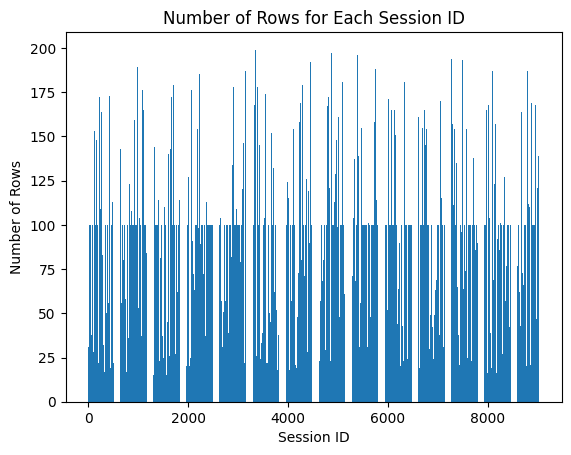

In [23]:
plt.bar(session_counts['Session_id'], session_counts['row_count'])
plt.xlabel('Session ID')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Session ID')
plt.show()

In [24]:
# We have 80903 sessions now. The range of session vary from : 1 - 19, all sessions below 1 will be trimed in next phase.
print(session_counts['row_count'].min())
print(session_counts['row_count'].max())


1
199


In [25]:
# We have only one session to be discarded.We will have 80902 sessions for train and test.
session_counts.sort_values(by =['row_count'],inplace= True)
print(session_counts)

      Session_id  row_count
6780        6781          1
6560        6561          7
1601        1602          9
6582        6583          9
6998        6999          9
...          ...        ...
5707        5708        199
1160        1161        199
1023        1024        199
5029        5030        199
1166        1167        199

[9032 rows x 2 columns]


In [26]:
#dropping the session with only one movie.
merged_df = merged_df[merged_df['Session_id'] != 6781]
merged_df.head

<bound method NDFrame.head of         user_id  movie_id  rating  unix_timestamp  Action  Adventure  \
34073         1      3186       4       978300019       0          0   
23270         1      1270       5       978300055       0          0   
31152         1      1721       4       978300055       0          0   
37339         1      1022       5       978300055       0          0   
28157         1      2340       3       978300103       0          0   
...         ...       ...     ...             ...     ...        ...   
746340     6040      2917       4       997454429       0          0   
172108     6040      1784       3       997454464       0          0   
271084     6040      1921       4       997454464       0          0   
365607     6040       161       3       997454486       0          0   
353819     6040      1221       4       998315055       1          0   

        Animation  Children's  Comedy  Crime  ...  Horror  Musical  Mystery  \
34073           0         

In [27]:
# converting to parquet file for NvTabular ETL(Extract, Transform, Load) phase.
merged_df.to_parquet('/content/drive/MyDrive/output_ses_100.parquet', index=False)